# MDHP-GDS: Multi-Dimensional Hawkes Process Gradient Descent Solver
This notebook is an example of how to use the MDHP-GDS. MDHP-GDS is a optimized solver for the problem of Multi-Dimensional Hawkes Process. Vectorized and broadcasting operations are implemented to calculate the maximum likelihood estimation of the parameters.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import font_manager

# Load Times New Roman font in case it is not installed
font_dirs = ["../fonts/Times New Roman"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

## Prepration

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import font_manager
import os
import os.path as osp

# Load Times New Roman font in case it is not installed
font_dirs = ["../fonts/Times New Roman"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

OUTPUT_DIR = osp.join(
    osp.dirname(osp.abspath(".")), "results", "examples", "mdhp-gds"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Section 1: Use MDHP-GDS directly

----------------------------------------------------
 __  __ _____  _    _ _____        _   _      _   
|  \/  |  __ \| |  | |  __ \      | \ | |    | |  
| \  / | |  | | |__| | |__) |_____|  \| | ___| |_ 
| |\/| | |  | |  __  |  ___/______| . ` |/ _ \ __|
| |  | | |__| | |  | | |          | |\  |  __/ |_ 
|_|  |_|_____/|_|  |_|_|          |_| \_|\___|\__|
----------------------------------------------------
     @Anonymous
----------------------------------------------------
Elapsed time: 3.7991626262664795


Model has diverged at epoch 175. Average loss change 0.060172 is above zero.


alpha: 
[[9.9999997e-10 9.9999997e-10 3.4586124e-02 9.9999997e-10 4.5782123e-02]
 [9.9999997e-10 9.9999997e-10 3.4586124e-02 9.9999997e-10 9.9999997e-10]
 [9.9999997e-10 9.9999997e-10 3.4586124e-02 9.9999997e-10 9.9999997e-10]
 [9.9999997e-10 1.9135033e-01 3.4586124e-02 7.2647934e-03 9.9999997e-10]
 [3.9337877e-02 9.9999997e-10 3.4586124e-02 9.9999997e-10 9.9999997e-10]]
beta: 
[[1.59645945e-01 1.88514050e-02 3.16562168e-02 1.08370714e-01
  1.06235154e-01]
 [1.59481660e-01 1.85604226e-02 3.44760679e-02 5.29514365e-02
  1.12462282e-01]
 [1.59565046e-01 1.88771859e-02 3.45861241e-02 1.08746856e-01
  1.59543008e-01]
 [1.49502769e-01 1.57968789e-01 3.44487987e-02 9.99999972e-10
  1.57403395e-01]
 [1.47127613e-01 6.67053927e-03 3.06667406e-02 1.07066162e-01
  1.59659192e-01]]
theta: 
[0.04132423 0.04470112 0.04462463 0.03644131 0.04334664]


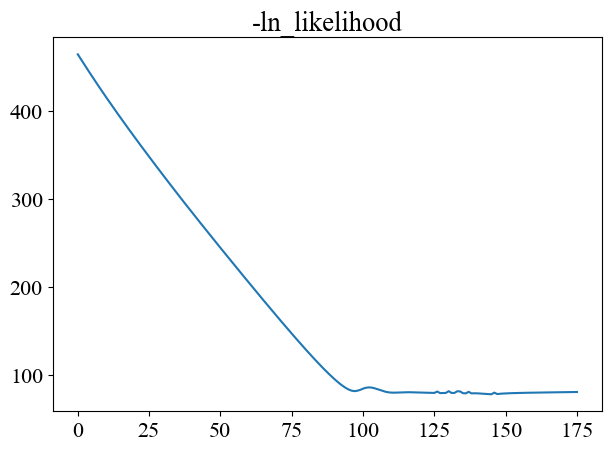

In [3]:
from matplotlib import pyplot as plt
from mdhpnet.models import MDHP_GDS
import torch
import time
times = [
    [0, 1, 2.4, 5.1,],
    [1, 3.2, 4],
    [],
    [1.4, 4.1, 6.2],
    [0.8, 2.1, 3.5, 5.2],
]
model = MDHP_GDS(timestamps=times)

start_time = time.time()
model = model.to("cuda:0")
# Sync cuda device
torch.cuda.synchronize()
print(f"Elapsed time: {time.time() - start_time}")

loss_list = model.fit(max_epochs=1000, check_interval=25)
alpha, beta, theta = model.get_parameters()
print(
    f"alpha: \n{alpha}\n"
    f"beta: \n{beta}\n"
    f"theta: \n{theta}"
)

fig = plt.figure()
plt.plot(loss_list)
plt.title("-ln_likelihood")
plt.tight_layout()

## Setction 2: Use `solve_mdhp_parameters` API

Model has converged at epoch 200. Average loss change -0.000021 is below tolerance 0.0001.


Text(0.5, 1.0, '-ln_likelihood')

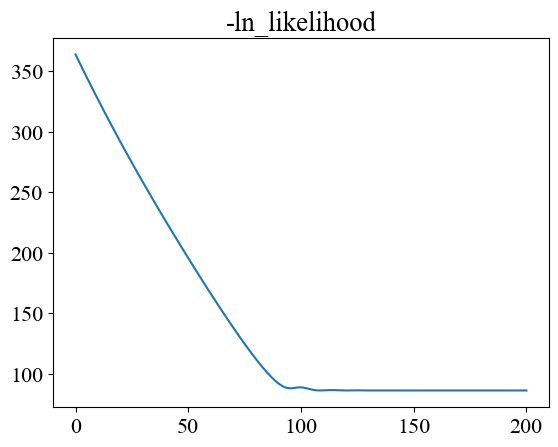

In [4]:
from mdhpnet.utils import solve_mdhp_params
import numpy as np

time = [
    [0, 1.4, 2.8],
    [],
    [3.1, 4.7, 5],
    [2, 2.5, 6, 7, 8, 9.8],
]

alpha, beta, theta = solve_mdhp_params(
    timestamps=time,
    device="cuda",
    loss_list_save_path=osp.join(OUTPUT_DIR, "loss_list.npy"),
)

loss_list = np.load(osp.join(OUTPUT_DIR, "loss_list.npy"))

fig = plt.figure()
plt.plot(loss_list)
plt.title("-ln_likelihood")

## Section 3: Example of Generating MDHP Parameters Data

Note that in our experiment, the data is generated with:
- [SOME-IP_Generator](https://github.com/Egomania/SOME-IP_Generator)
- [SISSA](https://github.com/tiara8735/SISSA)

All data should be in shape (`n_samples`, `window_size`, `n_features + 1`), where:
- `n_samples` is the number of message windows.
- `window_size` is the number of packets in each message window.
- `n_features` is the number of features of each packet. 
- `1` is the unique identifier (may either be source or destination)  of the packet. The identifier is used to map the packet to the corresponding dimension of the Hawkes process.

⚠️ **You may need to wait for a while for the code to finish.**

In [ ]:
import numpy as np
import os.path as osp
import logging
from typing import List

from mdhpnet.utils import solve_mdhp_params

# Where the raw data is stored
all_raw_data_paths = (
    # Shape: (n_samples, window_size, n_features + 1)
    "../data/raw/train_4_4/data.npy",
    # Shape: (n_samples, window_size, n_features + 1)
    "../data/raw/train_5_5/data.npy",
)

# Where the processed data will be stored
all_target_data_dirs = (
    osp.join(OUTPUT_DIR, "train_4_4"),
    osp.join(OUTPUT_DIR, "train_5_5"),
)

# All unique source IPs
# You can change this to destination IPs based on your data
# fmt: off
unique_src_ips = [
    10001, 10002, 10003, 10004, 10006, 10007, 10008, 10101, 
    10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109,
]
# fmt: on
# Dim of MDHP is the number of unique source IPs
mdhp_dim = len(unique_src_ips)

# Create a mapping from IP to index
ip_to_index = {ip: i for i, ip in enumerate(unique_src_ips)}


def get_timestamps(time: np.ndarray, ids: np.ndarray) -> List[List[float]]:
    """
    Get timestamps for each unique source IP.

    Parameters
    ----------
    time : np.ndarray
        Time of each message in a window
        Shape: (window_size,)
    ids : np.ndarray
        Source IP of each message in a window
        Shape: (window_size,)

    Returns
    -------
    List[List[float]]
        Timestamps for each unique source IP.
    """
    timestemps = [[] for _ in range(mdhp_dim)]
    for t, i in zip(time, ids):
        timestemps[ip_to_index[i]].append(t)
    return timestemps


for raw_data_path, target_data_dir in zip(all_raw_data_paths, all_target_data_dirs):
    print(f"Read data from {raw_data_path}")
    raw_data = np.load(raw_data_path)  # Shape: (n_samples, window_size, n_features + 1)
    print(f"Data shape: {raw_data.shape}")

    alphas, betas, thetas = [], [], []

    # Process each message window
    for idx in range(raw_data.shape[0]):
        msg_window = raw_data[idx]  # Shape: (window_size, n_features + 1)
        time = msg_window[:, 0] * 10
        ids = msg_window[:, -1]  # Get the source IPs
        mapped_timestamps = get_timestamps(time, ids)
        alpha, beta, theta = solve_mdhp_params(
            timestamps=mapped_timestamps,
            device="cuda:0",
            max_epochs=500,
            check_interval=25,
        )
        alphas.append(alpha)  # Shape: (mdhp_dim, mdhp_dim)
        betas.append(beta)  # Shape: (mdhp_dim, mdhp_dim)
        thetas.append(theta)  # Shape: (mdhp_dim,)

    alphas = np.array(alphas)  # Shape: (n_samples, mdhp_dim, mdhp_dim)
    betas = np.array(betas)  # Shape: (n_samples, mdhp_dim, mdhp_dim)
    thetas = np.array(thetas)  # Shape: (n_samples, mdhp_dim, mdhp_dim)

    # Drop the last column of raw_data
    np.save(
        osp.join(target_data_dir, "data.npy"), raw_data[:, :, 0:-1]
    )  # (30748, 128, 25)
    # Save the parameters of MDHP
    np.save(osp.join(target_data_dir, "alpha.npy"), alphas)  # (30748, 16, 16)
    np.save(osp.join(target_data_dir, "beta.npy"), betas)  # (30748, 16, 16)
    np.save(osp.join(target_data_dir, "theta.npy"), thetas)  # (30748, 16)

    print(f"Finished processing data: {raw_data_path}")